In [1]:
suppressPackageStartupMessages({
  library(dataorganizer)
  library(dplyr)
  library(magrittr)
  library(readr)
  library(ggplot2)
  library(Seurat)
  library(pagoda2)
  library(conos)
  library(Matrix)
  library(vpscutils)
  library(pheatmap)
})

devtools::load_all()

theme_set(theme_bw())

ℹ Loading segmentationErrorImpact
Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



## Load data

### scRNA-seq

In [2]:
cell_metadata <- DatasetPath("nsclc_rna", "GSE127465_human_cell_metadata_54773x25.tsv") %>% read_delim(show_col_types=FALSE, delim="\t")

cm <- DatasetPath("nsclc_rna", "GSE127465_human_counts_normalized_54773x41861.mtx") %>% readMM()
colnames(cm) <- DatasetPath("nsclc_rna", "GSE127465_gene_names_human_41861.tsv") %>% read.table() %>% .$V1
rownames(cm) <- make.unique(cell_metadata$Barcode)

cm <- cm / rowSums(cm) * cell_metadata$`Total counts`
cm@x <- round(cm@x)

DatasetPath("nsclc_rna", "cm_raw.rds") %>% write_rds(x=cm)

In [29]:
so_rna <- t(cm) %>% CreateSeuratObject(meta.data=data.frame(cell_metadata)) %>% NormalizeData()

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts



In [4]:
annotation <- cell_metadata$`Major cell type` %>% setNames(rownames(cm))

In [5]:
# table(cell_metadata$`Major cell type`, cell_metadata$`Minor subset`)

In [6]:
# mask <- cell_metadata$`Major cell type` %>% {!grepl("-specific", .)}
# cell_metadata %<>% .[mask,]
# cm %<>% .[mask,]

In [7]:
cm_per_sample <- rownames(cm) %>% split(cell_metadata$Patient) %>% lapply(\(cbs) cm[cbs,])

In [8]:
cell_metadata$Patient %>% table()

.
   p1    p2    p3    p4    p5    p6    p7 
15416  5166 11345  5403  4576  6010  6857 

In [31]:
so_rna %<>%
    FindVariableFeatures(selection.method="vst", nfeatures = 2000) %>%
    ScaleData() %>%
    RunPCA(., features=VariableFeatures(.)) %>%
    FindNeighbors(dims=1:30)

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  KRT19, TM4SF1, HSPB1, TACSTD2, ANXA2, LGALS3BP, KRT8, CDH1, MAL2, DSP 
	   CD9, EFNA1, EPCAM, KRT18, CLDN7, MUC1, ATP1B1, PERP, JUP, CLDN4 
	   S100A16, CEACAM6, FXYD3, SDC4, LAD1, SFN, DDR1, ELF3, AGR2, RAB25 
Negative:  S100A8, S100A9, CD79A, S100A12, RGS1, CD69, PROK2, PRF1, NKG7, GZMA 
	   TRAT1, GZMK, GNLY, GZMB, IGHM, CD8B, KLRD1, PADI4, POU2F2, TBX21 
	   KLRF1, IGKC, RGS18, JCHAIN, GZMH, MZB1, FGFBP2, CTLA4, FOLR3, TRGC2 
PC_ 2 
Positive:  KRT19, PERP, DSP, KRT8, MAL2, KRT18, TM4SF1, TACSTD2, FXYD3, EPCAM 
	   CDH1, EFNA1, SFN, MUC1, KRT6A, CEACAM6, CLDN4, LAD1, CLDN7, PKP1 
	   COL17A1, RAB25, S100A16, SDC1, AGR2, KRT17, KRT5, AKR1C3, ELF3, TMPRSS4 
Negative:  C1QA, C1QB, APOE, CTSB, MRC1, CD163, CTSL, GPNMB, APOC1, SLCO2B1 
	   HLA-DRB1, MS4A7, VSIG4, CTSZ, HLA-DRA, TMEM176B, ACP5, CTSD, GRN, MS4A4A 
	   GM2A, C1QC, PSAP, PLTP, LYZ, CCL18, HLA-DPA1, LIPA, HLA-DPB1, TNFSF13 
PC_ 3 

In [32]:
so_rna %<>%
    RunUMAP(dims=1:30, n.epochs=500) %>%
    FindClusters(resolution = 1.5, algorithm=2)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
04:00:37 UMAP embedding parameters a = 0.9922 b = 1.112

04:00:37 Read 54773 rows and found 30 numeric columns

04:00:37 Using Annoy for neighbor search, n_neighbors = 30

04:00:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:00:42 Writing NN index file to temp file /tmp/RtmpEJkCwU/filefaced44cf23c1

04:00:42 Searching Annoy index using 1 thread, search_k = 3000

04:01:00 Annoy recall = 100%

04:01:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 54773
Number of edges: 2016135

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8814
Number of communities: 38
Elapsed time: 12 seconds


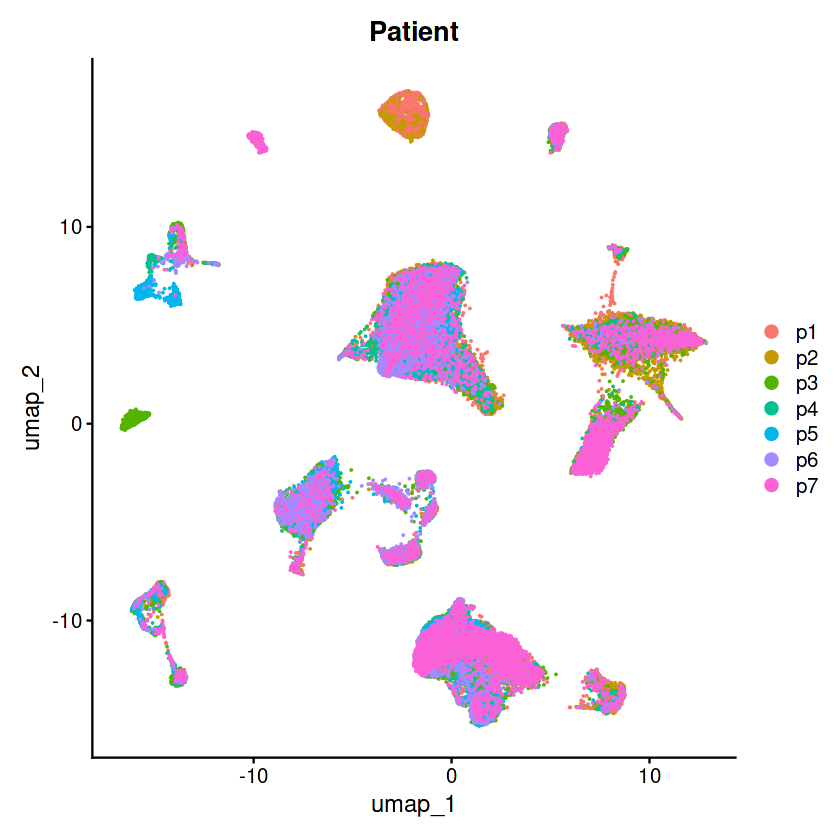

In [33]:
UMAPPlot(so_rna, group.by='Patient')

In [43]:
so_rna[['umap_paper']] <- cell_metadata[,c('x_NSCLC_all_cells', 'y_NSCLC_all_cells')] %>%
    rename(UMAP_1=`x_NSCLC_all_cells`, UMAP_2=`y_NSCLC_all_cells`) %>%
    as.matrix() %>% set_rownames(cell_metadata$Barcode) %>%
    CreateDimReducObject(key='UMAP_', assay='RNA')

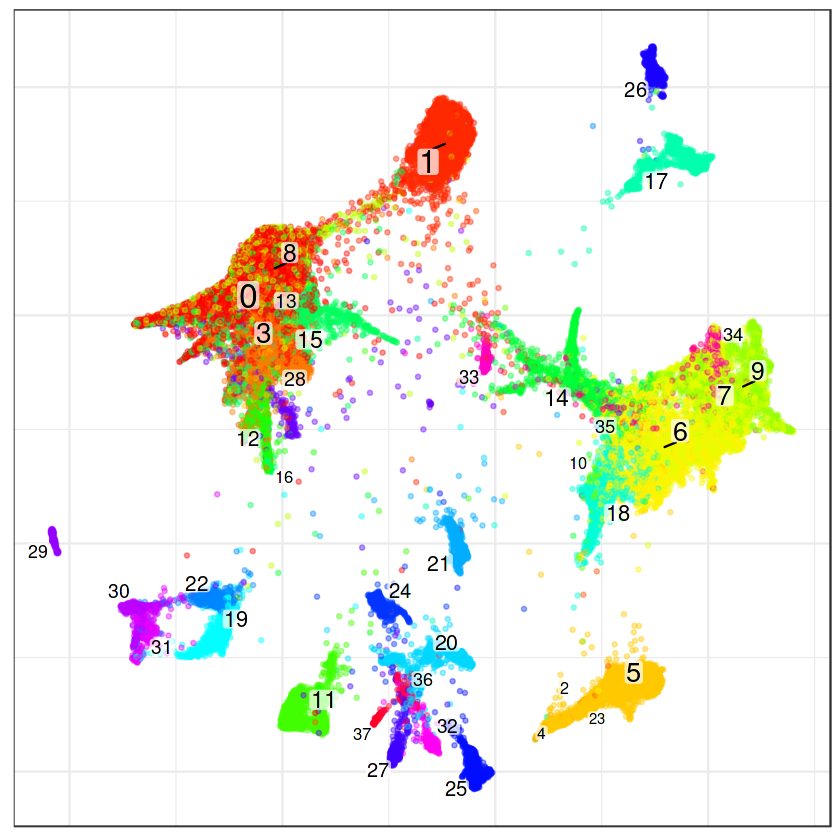

In [39]:
so_rna@meta.data[,c('x_NSCLC_all_cells', 'y_NSCLC_all_cells')] %>% na.omit() %>%
    embeddingPlot(groups=so_rna$seurat_clusters)

### Spatial

In [9]:
so <- DatasetPath("nsclc", "so.rds") %>% read_rds()

In [10]:
so_subset <- subset(so, cells=names(which(so$rna_Run_Tissue_name == "Lung5_Rep1")))
cm_spatial <- so_subset[["rna"]]$counts

In [11]:
common_genes <- lapply(cm_per_sample, colnames) %>% {Reduce(intersect, .)} %>% intersect(rownames(cm_spatial))

## Adjust annotation

In [12]:
annotation_rna <- cell_metadata$`Major cell type` %>% setNames(rownames(cm))
annotation_spatial <- so_subset$rna_cell_type

annotation_rna[grep("Mono", cell_metadata$`Minor subset`)] <- "monocyte"
annotation_rna[grep("Mac", cell_metadata$`Minor subset`)] <- "macrophage"

annotation_rna[grep("DC\\d?$", cell_metadata$`Minor subset`)] <- "DC"
annotation_spatial[annotation_spatial %in% c("mDC", "pDC")] <- "DC"

# Basophils and Platelets only align with some tumor cells, so I don't assign them
annotation_rna[annotation_rna == "bBasophils"] <- "Basophils"
annotation_rna[annotation_rna == "bPlatelets"] <- "Platelets"
annotation_rna[annotation_rna %in% c("bNeutrophils", "tNeutrophils")] <- "neutrophil"
annotation_rna[annotation_rna %in% c("Type I cells", "Type II cells")] <- "epithelial"
annotation_rna[annotation_rna == "Endothelial cells"] <- "endothelial"
annotation_rna[annotation_rna == "Fibroblasts"] <- "fibroblast"

# RBC cells don't align to anything
annotation_rna[annotation_rna %in% c("bRBC", "tRBC")] <- "RBC"

annotation_rna[annotation_rna %in% c("bPlasma cells", "tPlasma cells")] <- "plasmablast"
annotation_rna[annotation_rna %in% c("bMast cells", "tMast cells")] <- "mast"
annotation_rna[annotation_rna %in% c("bNK cells", "tNK cells")] <- "NK"

annotation_rna[annotation_rna %in% c("bB cells", "tB cells")] <- "B cells"
annotation_spatial[annotation_spatial %in% c("B-cell")] <- "B cells"

annotation_rna[annotation_rna %in% c("bT cells", "tT cells")] <- "T cells"
annotation_spatial[startsWith(annotation_spatial, "T ") | startsWith(annotation_spatial, "Treg")] <- "T cells"

## Align T cells

In [13]:
p2s_t <- lapply(cm_per_sample, \(scm) {
    scm[annotation_rna[rownames(scm)] == "T cells", common_genes] %>% t() %>% GetPagoda(
        embeding.type="UMAP", n.pcs=30, var.scale=TRUE, n.odgenes=1000, log.scale=TRUE,
        clustering.type=NULL, min.dist=0.1, spread=2, verbose=FALSE
    )
})

03:48:11 UMAP embedding parameters a = 0.5447 b = 0.8421

03:48:11 Read 3550 rows and found 30 numeric columns

03:48:11 Using Annoy for neighbor search, n_neighbors = 15

03:48:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:48:11 Writing NN index file to temp file /tmp/RtmpEJkCwU/filefaced1cd907d1

03:48:11 Searching Annoy index using 30 threads, search_k = 1500

03:48:11 Annoy recall = 100%

03:48:12 Commencing smooth kNN distance calibration using 30 threads
 with target n_neighbors = 15

03:48:13 Initializing from normalized Laplacian + noise (using RSpectra)

03:48:13 Commencing optimization for 500 epochs, with 79374 positive edges using 30 threads

03:48:14 Optimization finished

03:48:14 UMAP embedding parameters a = 0.5447 b = 0.8421

03:48:14 Read 280 

In [14]:
p2_t_spatial <- cm_spatial %>% .[,annotation_spatial[colnames(.)] == "T cells"] %>% GetPagoda(
    embeding.type="UMAP", n.pcs=30, var.scale=TRUE, n.odgenes=600, log.scale=FALSE,
    clustering.type=NULL, min.dist=0.1, spread=2
)

9859 cells, 960 genes; normalizing ... 

Using plain model 

Winsorizing ... 

done.


calculating variance fit ...

 using gam 

71 overdispersed genes ... 71

persisting ... 

done.

running PCA using 600 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


03:48:39 UMAP embedding parameters a = 0.5447 b = 0.8421

03:48:39 Read 9859 rows and found 30 numeric columns

03:48:39 Using Annoy for neighbor search, n_neighbors = 15

03:48:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:48:40 Writing NN index file to temp file /tmp/RtmpEJkCwU/filefaced4307258b

03:48:40 Searching Annoy index using 30 threads, search_k = 1500

03:48:40 Annoy recall = 100%

03:48:40 Commencing smooth kNN distance calibration using 30 threads
 with target n_neighbors = 15

03:48:42 Initializing from normalized Laplacian + noise (using RSpectra)

03:48:42 Commencing optimization for 500 epochs, with 212628 positive edges using 30 threads

03:48:43 Optimization finished



In [15]:
con_t <- c(p2s_t, list(Lung5_Rep1=p2_t_spatial)) %>% Conos$new(n.cores=50)
con_t$buildGraph(k=50, k.self=5, k.self.weight=0.1)

found 0 out of 28 cached PCA space pairs ... 

running 28 additional PCA space pairs 

 done

inter-sample links using mNN 

 done

local pairs 

 done


building graph .



.

done



In [16]:
cm_t <- con_t$getJointCountMatrix()

In [16]:
con_t$embedGraph(
    method="UMAP", min.prob.lower=1e-5, n.neighbors=30, n.epochs=1000,
    spread=2.0, min.dist=0.1, verbose=FALSE
)

Warning message in con_t$embedGraph(method = "UMAP", min.prob.lower = 1e-05, n.neighbors = 30, :
“Already created an embedding: UMAP. Overwriting.”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Warning message in uwot(X = X, n_neighbors = n_neighbors, n_components = n_components, :
“n_components > number of columns in input data: 2 > 1, this may give poor or unexpected results”


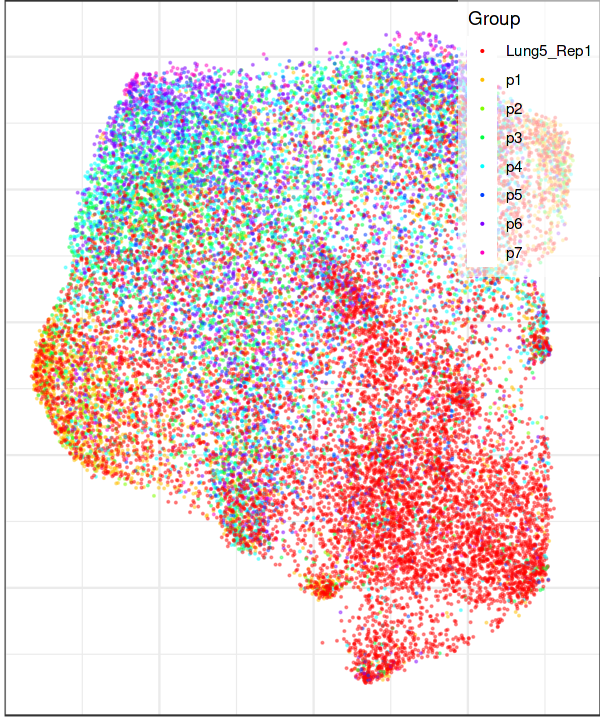

In [18]:
con_t$plotGraph(
    color.by="sample", plot.na=-1, size=0.1, mark.groups=FALSE,
    show.legend=TRUE, legend.position=c(1, 1)
)

In [30]:
con_t$findCommunities(method=conos::leiden.community, resolution=2, n.iterations=10)

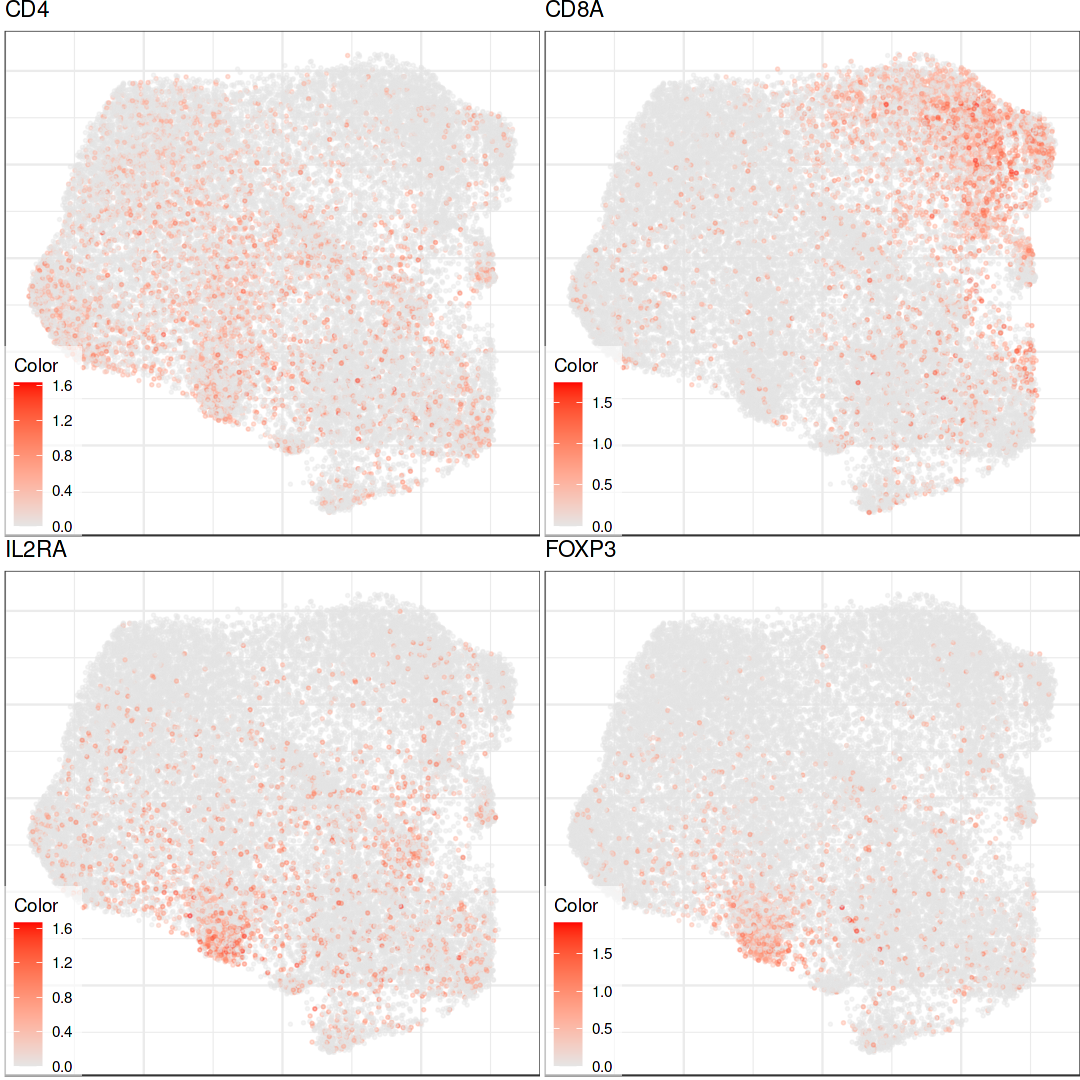

In [29]:
options(repr.plot.width=9, repr.plot.height=9)
c("CD4", "CD8A", "IL2RA", "FOXP3") %>% lapply(\(pg) {
    con_t$plotGraph(
        colors=log10(cm_t[,pg] + 1), size=0.5, title=pg,
        show.legend=TRUE, legend.position=c(0, 0)
    )
}) %>% cowplot::plot_grid(plotlist=., ncol=2)

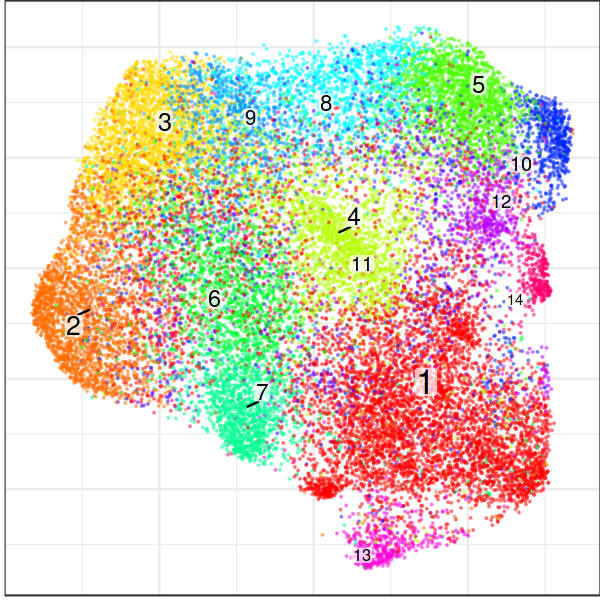

In [32]:
options(repr.plot.width=5, repr.plot.height=5)
con_t$plotGraph(clustering="leiden", plot.na=-1, size=0.1)

In [596]:
# marker_mat_clust <- con_t$clusters$leiden$groups %>%
#     .[names(.) %in% rownames(cm_joint)] %>%
#     {split(names(.), .)} %>% #.[startsWith(names(.), "T")] %>%
#     sapply(\(cids) colMeans(con_t$getJointCountMatrix()[cids,]))

### T annotation

In [162]:
annotation_joint <- c(annotation_spatial, annotation_rna)

c_clusts <- con_t$clusters$leiden$groups
cd8_clusts <- c(5, 10, 12, 8, 14)
annotation_joint[names(c_clusts)[!(c_clusts %in% cd8_clusts)]] <- "CD4+ T cells"
annotation_joint[names(c_clusts)[c_clusts %in% cd8_clusts]] <- "CD8+ T cells"
annotation_joint[names(c_clusts)[(c_clusts %in% 7)]] <- "Treg"

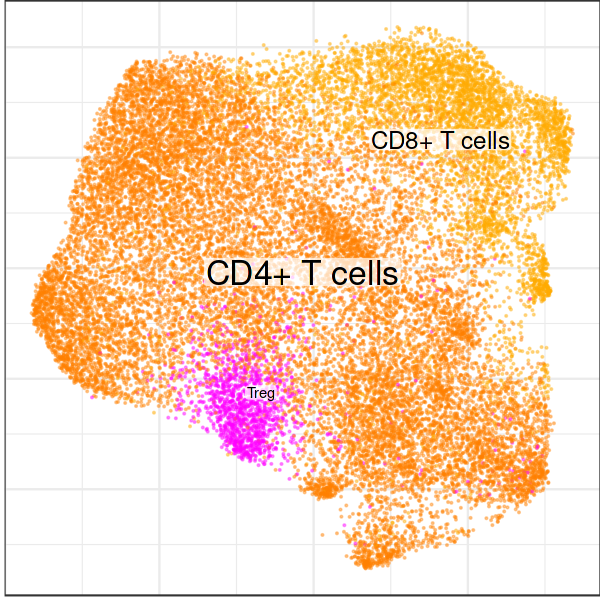

In [36]:
options(repr.plot.width=5, repr.plot.height=5)
con_t$plotGraph(groups=annotation_joint, plot.na=-1, size=0.1)

## Marker plots

In [163]:
so_subset$annotation <- annotation_joint[colnames(so_subset)]
Idents(so_subset) <- as.character(so_subset$annotation) %>% factor(levels=sort(unique(.)))

so_rna$annotation <- annotation_joint[colnames(so_rna)]
Idents(so_rna) <- as.character(so_rna$annotation) %>% factor(levels=sort(unique(.)))

In [64]:
# table(annotation_joint[colnames(so_subset)]) %>% names() %>% {paste0('`', ., '`=c()')} %>% paste(collapse=",\n") %>% cat()

In [139]:
# Unless specified otherwise, the markers were taken from the Integration publication
markers_per_type <- list(
    `B cells`=c('MS4A1'),
    `CD4+ T cells`=c("IL7R", "CD8A"), # IL7R is from nanostring
    `CD8+ T cells`=c("IL7R", "CD4"),
    `Ciliated cells`=c(), # TODO
    `DC`=c("HLA-DPB1", "CD163", "C1QB"), # first nanostring, others de-novo
    `endothelial`=c('VWF'),
    `epithelial`=c('LTF', 'LAMP3', 'AQP3'), # nanostring
    `fibroblast`=c('COL1A1', 'COL1A2', 'DCN'),
    `macrophage`=c('SPP1', 'MMP12'), # nanostring
    `mast`=c('TPSAB1', 'CPA3'),
    `monocyte`=c('S100A8', 'VCAN', 'FGR'), # nanostring
    `neutrophil`=c('CXCR2', 'CXCL8', 'HCAR2'), # nanostring
    `NK`=c('NKG7', 'PRF1'), # nanostring
    `plasmablast`=c('IGHG2', 'MZB1'),
    # `Smooth muscle cells`=c('RGS5'), # this type is not present in spatial
    `Treg`=c("IL7R", "IL2RA", "FOXP3")
)

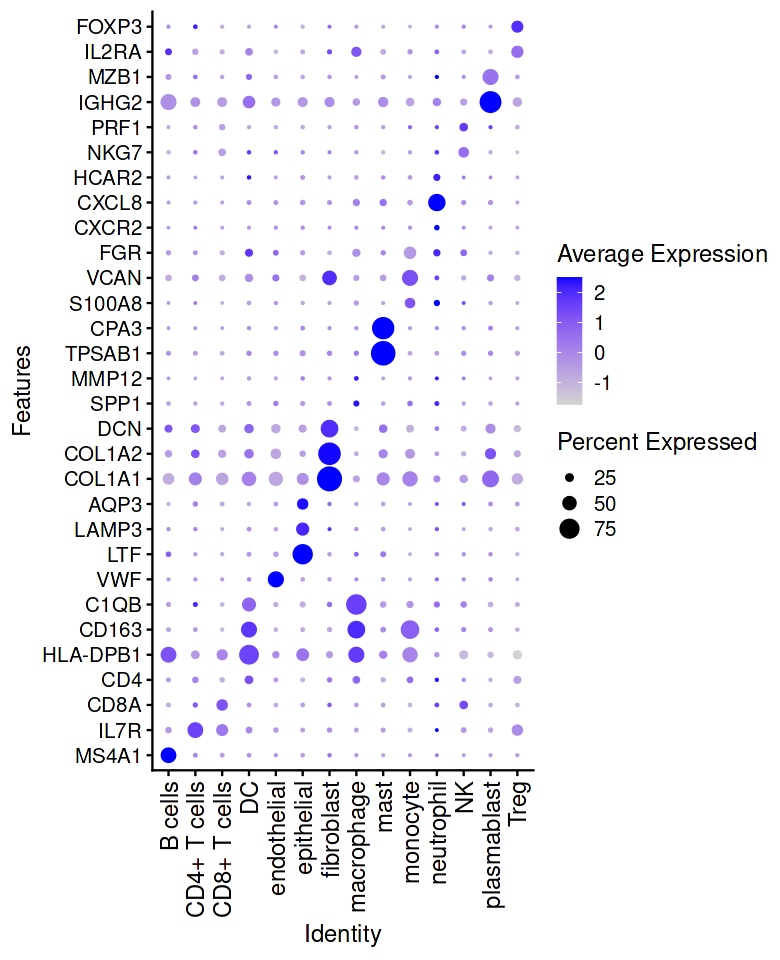

In [171]:
so_subset %>%
    subset(cells=colnames(.)[!startsWith(annotation_joint[colnames(.)], "tumor")]) %>%
    DotPlot(features=unique(unlist(markers_per_type))) +
        theme(axis.text.x=element_text(angle = 90, hjust = 1, vjust=0.5, size=14)) +
        coord_flip()

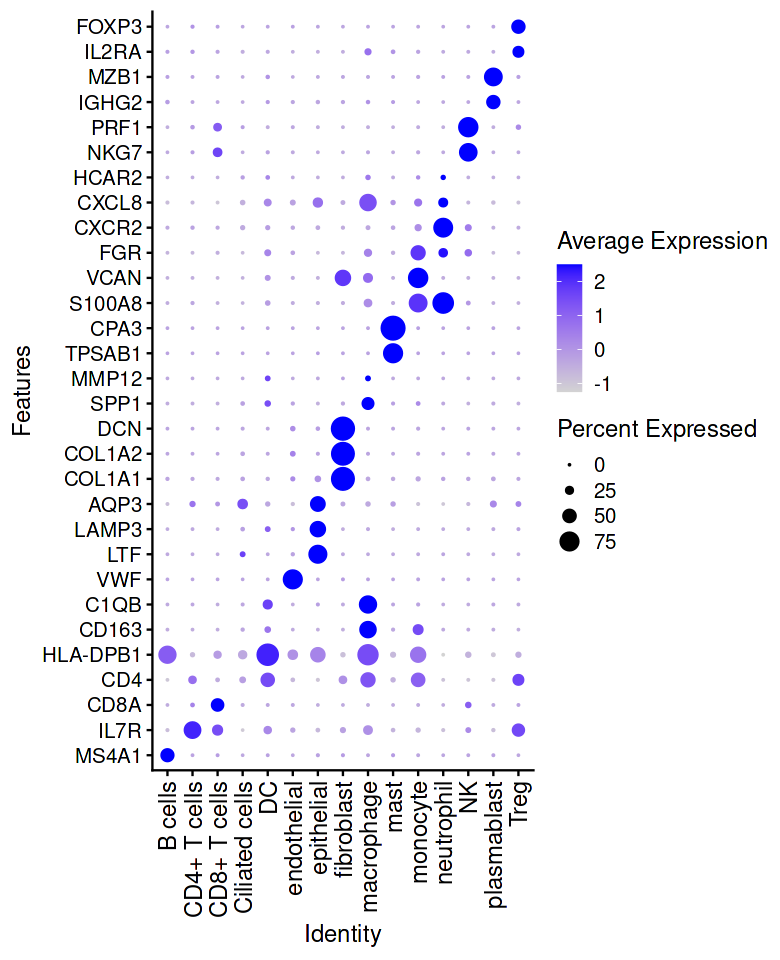

In [170]:
options(repr.plot.width=6.5, repr.plot.height=8)
so_rna %>%
    # subset(cells=colnames(.)[!startsWith(annotation_joint[colnames(.)], "Patient")]) %>%
    subset(cells=colnames(.)[annotation_joint[colnames(.)] %in% names(markers_per_type)]) %>%
    DotPlot(features=unique(unlist(markers_per_type))) +
        theme(axis.text.x=element_text(angle = 90, hjust = 1, vjust=0.5, size=14)) +
        coord_flip()

## Save

### Save the annotation

In [175]:
annotation_joint[names(annotation_rna)] %>%
    as.data.frame() %>% tibble::rownames_to_column() %>% set_colnames(c("cell", "cell_type")) %>%
    write_csv(DatasetPath("nsclc_rna", "annotation_adj.csv"))

In [180]:
c_ann <- annotation_joint[names(annotation_spatial)] %>%
    as.data.frame() %>% tibble::rownames_to_column() %>% set_colnames(c("cell", "cell_type"))

c_ann$fov <- tann$cell %>% strsplit("_") %>% sapply(\(cx) cx[3])
c_ann$cell_id <- tann$cell %>% strsplit("_") %>% sapply(\(cx) cx[4])

write_csv(c_ann, DatasetPath("nsclc", "Lung5_Rep1", "Lung5_Rep1-Flat_files_and_images", "annotation_adj.csv"))

### Seurat

In [52]:
so_rna$cell_type <- DatasetPath("nsclc_rna", "annotation_adj.csv") %>% read.csv() %$%
    setNames(cell_type, cell) %>% .[colnames(so_rna)]

In [54]:
so_rna %>% write_rds(DatasetPath("nsclc_rna", "so.rds"))

### Long list of markers

In [222]:
so_rna$annotation_adj <- so_rna$annotation
so_rna$annotation_adj[startsWith(so_rna$annotation_adj, "Patient")] <- "tumor"
Idents(so_rna) <- so_rna$annotation_adj

TODO: only use genes shared with spatial data, but output scores for all genes!

In [229]:
markers_rna <- FindAllMarkers(
    subset(so_rna, features=rownames(so_subset)),
    return.thresh=10.0, min.pct=-1, logfc.threshold=-1
)

Calculating cluster CD4+ T cells

Calculating cluster monocyte

Calculating cluster DC

Calculating cluster NK

Calculating cluster B cells

Calculating cluster neutrophil

Calculating cluster Platelets

Calculating cluster plasmablast

Calculating cluster CD8+ T cells

Calculating cluster RBC

Calculating cluster Treg

Calculating cluster Basophils

Calculating cluster T cells

Calculating cluster bMyeloid precursor-like

Calculating cluster tumor

Calculating cluster macrophage

Calculating cluster fibroblast

Calculating cluster mast

Calculating cluster Club cells

Calculating cluster endothelial

Calculating cluster epithelial

Calculating cluster Ciliated cells

Calculating cluster Smooth muscle cells

Calculating cluster ND

Warning message:
“The following tests were not performed: ”
Warning message:
“When testing T cells versus all:
	Cell group 1 has fewer than 3 cells”


In [232]:
markers_rna_adj <- split(markers_rna, ~cluster)
markers_rna_adj$`T cells` <- NULL

markers_rna_adj <- names(markers_rna_adj) %>% setNames(., .) %>% sccore::plapply(\(cn) {
    markers_rna_adj[[cn]] %>% rename(Gene=gene) %>% sccore::appendSpecificityMetricsToDE(
        clusters=Idents(so_rna), cluster.id=cn, p2.counts=t(so_rna[["RNA"]]$data), append.auc=TRUE
    )
}, n.cores=40)

In [233]:
bind_rows(markers_rna_adj) %>% as_tibble() %>%
    write_csv(DatasetPath("nsclc_rna", "markers.csv"))

In [ ]:
# markers_spatial <- FindAllMarkers(so_subset)

In [214]:
# markers_spatial_adj <- split(markers_spatial, ~cluster)
# markers_spatial_adj <- names(markers_spatial_adj) %>% setNames(., .) %>% sccore::plapply(\(cn) {
#     markers_spatial_adj[[cn]] %>% rename(Gene=gene) %>% sccore::appendSpecificityMetricsToDE(
#         clusters=Idents(so_subset), cluster.id=cn, p2.counts=t(so_subset[["rna"]]$data), append.auc=TRUE
#     )
# }, n.cores=40)

## Prepare spatial transcript files

In [ ]:
tx_dat1 <- DatasetPath('nsclc', 'Lung5_Rep1', 'Lung5_Rep1-Flat_files_and_images', 'Lung5_Rep1_tx_file.csv') %>%
  read.csv()
tx_dat1$cell <- paste0('c_1_',tx_dat1$fov,'_',tx_dat1$cell_ID)

tx_dat2 <- DatasetPath('nsclc', 'Lung5_Rep2', 'Lung5_Rep2-Flat_files_and_images', 'Lung5_Rep2_tx_file.csv') %>%
  read.csv()
tx_dat2$cell <- paste0('c_2_',tx_dat2$fov,'_',tx_dat2$cell_ID)

tx_dat3 <- DatasetPath('nsclc', 'Lung5_Rep3', 'Lung5_Rep3-Flat_files_and_images', 'Lung5_Rep3_tx_file.csv') %>%
  read.csv()
tx_dat3$cell <- paste0('c_3_',tx_dat3$fov,'_',tx_dat3$cell_ID)

tx_dat <- rbind.data.frame(tx_dat1,tx_dat2,tx_dat3)

# saving rds version for faster loadings
DatasetPath('nsclc', 'tx_dat_all_reps.rds') %>% {write_rds(tx_dat, .)}